# Random forest 

Add description. 

Import libraries. 

In [1]:
# Import necessary libraries
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, confusion_matrix
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 
from collections import Counter

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train_res = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/X_train_res.csv')
y_train_res = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/y_train_res.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/X_test.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/y_test.csv')

X_train_res = X_train_res.drop(columns='Unnamed: 0', axis=1)
y_train_res = y_train_res.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

# Convert the DataFrame to a NumPy array
# y_test = y_test.to_numpy()

# Display the first few rows of each dataframe to verify the loading
print("X_train_res:")
display(X_train_res.head())

print("\ny_train_res:")
display(y_train_res.head())

print("\nX_test:")
display(X_test.head())

print("\ny_test:")
# print(y_test)
display(y_test.head())

# Convert the DataFrame to a 1-dimensional NumPy array
y_train_res = y_train_res.values.ravel()
y_test = y_test.values.ravel()


X_train_res:


,VVR_1,VVR_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,12.0,13.0,-0.070220,-0.403569,-0.161650,0.428359,-0.673859,-0.387663,0.994371,0.345623,...,-0.537730,0.225549,-1.036133,-0.951754,-1.025247,-1.526773,-1.479742,-1.237893,-2.161830,-2.049390
1,10.0,10.0,2.226447,1.288304,1.124217,0.514376,0.729448,1.091318,3.433959,2.208680,...,0.774622,0.458331,0.368352,0.632011,1.209277,-0.225126,-0.001447,0.619766,-0.202961,-0.127515
2,8.0,8.0,-0.328541,-0.286339,-0.049149,0.514376,-0.191466,-0.152619,-0.351110,-0.286124,...,0.539267,0.408449,0.316323,0.450683,-0.834081,-0.909004,-0.642000,0.297037,-1.125698,-0.981679
3,10.0,8.0,-0.179816,1.024130,0.956659,0.514376,0.292720,0.824388,-0.176376,0.226388,...,0.891064,0.458331,0.480862,0.766552,-0.208294,0.810246,0.749643,0.257680,0.422548,0.743912
4,8.0,8.0,-0.687261,-0.791730,-0.584920,0.514376,-0.763173,-0.767495,-0.530851,-0.455929,...,-0.558621,0.366881,-0.858611,-0.877156,-0.419249,-0.490562,-0.230352,-0.340549,-0.573360,-0.444615



y_train_res:


,VVR_group
0,1
1,1
2,0
3,0
4,0



X_test:


,VVR_1,VVR_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,10.0,11.0,-1.088267,-0.486929,-0.245322,-0.094909,-0.387079,-0.373556,-0.296967,1.267608,...,-1.106604,-1.661648,-0.939358,-1.258986,-0.862599,0.657150,0.649175,0.619766,0.540339,0.684272
1,19.0,21.0,0.160204,0.681681,0.725849,0.514376,0.751085,0.775827,0.031562,0.457413,...,1.791290,0.458331,1.507769,1.887518,-0.111414,0.662918,0.653014,0.478080,0.552052,0.691181
2,8.0,8.0,-0.510947,-0.678086,-0.451146,-0.130749,-0.740730,-0.650167,-0.512662,-0.414737,...,0.412202,0.458331,-0.395816,0.012935,0.703933,1.133047,0.952462,0.619766,0.765365,1.028129
3,21.0,21.0,1.139765,0.115481,0.300321,0.406855,0.152945,0.239720,0.621775,-0.239594,...,-0.009577,0.017708,-0.227168,-0.190216,1.476715,0.191834,0.323467,0.493823,0.412243,0.350324
4,11.0,8.0,1.257027,1.622690,1.325337,0.514376,1.084273,1.365502,1.155021,1.601645,...,0.075374,0.217235,-0.256234,-0.149869,-0.194813,-0.655535,-0.383937,-0.104406,-0.685164,-0.617897



y_test:


,VVR_group
0,0
1,1
2,0
3,1
4,0


# Model (not complete but a intermediate step)

Strange enough the recall is much higher (0.27 instead of 0.18) when I don't use class weights. 

The model you can see here is not using K-fold cross validation. 

Here I haven't done any Recursive Feature Analysis or cross validation. 

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
from collections import Counter

# Train the RandomForestClassifier directly on the resampled training data
rf_classifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
rf_classifier.fit(X_train_res, y_train_res)

columns_to_drop = [ 'ID', 'Sum_12', 'Sum_4567', 'Sum_456', 'VVR_group', 'Condition', 'Date', 'Gender'] 

# Predict on the test data
pred = rf_classifier.predict(test.drop(columns=columns_to_drop, axis=1))

# Calculate evaluation metrics
accuracy = accuracy_score(test['VVR_group'].values, pred)
report = classification_report(test['VVR_group'].values, pred)
cm = confusion_matrix(test['VVR_group'].values, pred)
precision, recall, _ = precision_recall_curve(test['VVR_group'].values, pred)
auc_pr = auc(recall, precision)

# Print results
print(f"Accuracy on Validation Data: {accuracy}")
print(f"AUC-PR on Validation Data: {auc_pr}")
print("Classification Report:")
print(report)


Accuracy on Validation Data: 0.78125
AUC-PR on Validation Data: 0.4709821428571429
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        25
           1       0.50      0.29      0.36         7

    accuracy                           0.78        32
   macro avg       0.66      0.60      0.62        32
weighted avg       0.75      0.78      0.76        32



# Recursive feature elimination to optimize the scores - not using SMOTE

I based my code partially on the following article: 
https://machinelearningmastery.com/rfe-feature-selection-in-python/

Here I did apply cross validation, but not yet with hyperparameter tuning, so it's not the final model yet. 

For this step we don't use SMOTE because you can't specify what the test and train set is. So here I make a X and y and use this. 

Recall. 

In [24]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train_res, y_train_res, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Recall: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# Fit the pipeline on the entire dataset
pipeline.fit(X_test, y_test)

# Get the selected features
selected_features = X_test.columns[rfe.support_]
print("Selected Features:")
print(selected_features)


Recall: 0.899 (0.127)
Selected Features:
Index(['VVR_1', 'VVR_2', 'AU04_r__variance', 'AU04_r__standard_deviation',
       'AU04_r__maximum', 'AU04_r__mean', 'AU04_r__root_mean_square',
       'AU09_r__variance', 'AU09_r__standard_deviation', 'AU09_r__mean',
       'AU09_r__root_mean_square', 'AU10_r__mean', 'AU14_r__maximum',
       'AU23_r__sum_values', 'AU26_r__sum_values',
       'AU26_r__standard_deviation', 'AU26_r__mean',
       'AU26_r__root_mean_square', 'AU45_r__sum_values',
       'AU45_r__root_mean_square'],
      dtype='object')


Precision. 

In [60]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Precision: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# Fit the pipeline on the entire dataset
pipeline.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:")
print(selected_features)


/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dio

Precision: 0.492 (0.363)
Selected Features:
Index(['VVR_1', 'AU05_r__mean', 'AU17_r__variance', 'AU20_r__sum_values',
       'AU26_r__sum_values'],
      dtype='object')


Accuracy. 

In [59]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# Fit the pipeline on the entire dataset
pipeline.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:")
print(selected_features)


Accuracy: 0.809 (0.085)
Selected Features:
Index(['VVR_1', 'AU05_r__sum_values', 'AU15_r__standard_deviation',
       'AU20_r__sum_values', 'AU26_r__sum_values'],
      dtype='object')


# Model including RFE and hyperparameter tuning in Grid Search (not yet with inner and outer split!)

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Create the pipeline with RFE and the model
rfe_new = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model_new = RandomForestClassifier()
pipeline_new = Pipeline(steps=[('s', rfe_new), ('m', model_new)])

# Hyperparameter tuning using grid search
param_grid = {
    'm__n_estimators': [100, 200, 300],  # Number of trees in the forest
    # 'm__max_depth': [None, 10, 20],  # Maximum depth of the tree
    # 'm__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    # 'm__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    # 's__n_features_to_select': [5, 10, 15]  # Number of features to select with RFE
}
grid_search = GridSearchCV(pipeline_new, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_res, y_train_res, cv=cv, scoring='recall')

# Print cross-validation scores
print("Cross-validation scores: ", cv_scores)
print("Mean CV recall: ", cv_scores.mean())
print("Standard deviation of CV recall: ", cv_scores.std())

# Print best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Metrics to evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# from sklearn.metrics import roc_auc_score

# # Compute AUC-ROC per class
# y_pred_proba = np.array(best_model.predict_proba(X_test)) # Get predicted probabilities

# print(y_pred_proba)
# print(y_pred_proba.shape)
# print(y_test.shape)

# auc_per_class = roc_auc_score(y_test.values, y_pred_proba, average=None)

# # Print AUC-ROC per class
# print("AUC-ROC per class:")
# for i, auc in enumerate(auc_per_class):
#     print(f"Class {i}: {auc}")


Cross-validation scores:  [0.75       0.90909091 0.72727273 0.90909091 1.        ]
Mean CV recall:  0.8590909090909091
Standard deviation of CV recall:  0.10405021038417814
Best parameters found:
{'m__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        25
           1       0.62      0.71      0.67         7

    accuracy                           0.84        32
   macro avg       0.77      0.80      0.78        32
weighted avg       0.85      0.84      0.85        32



# Model with inner and outer split

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 

In [3]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import SVR


# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
rfe = RFE(estimator=DecisionTreeClassifier())
# rfe = RFE(SVR(kernel="linear"))
# rfe = RFE(SVC(kernel="linear"))
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

param_grid = {
    'm__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'm__class_weight': [{0: 0.6428571428571429, 1: 2.25}, None],  # Class weights
    'm__max_depth': [None, 10, 20],  # Maximum depth of the tree
    's__n_features_to_select': [5, 10, 20, 40, 60, 80]  # Number of features to select with RFE
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_res, y_train_res, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_res.shape)
print(y_train_res.shape)

# Fit model to training data to get best parameters
model.fit(X_train_res, y_train_res)

# Print best parameters
print(model.best_params_)

# Print the features that were selected with RFE

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")

# # For class 0
# precision_0, recall_0, _ = precision_recall_curve(y_test, y_proba[:, 0], pos_label=0)
# auc_pr_0 = auc(recall_0, precision_0)
# print(f"AUC-PR for class 0: {auc_pr_0:.3f}")

# # For class 1
# precision_1, recall_1, _ = precision_recall_curve(y_test, y_proba[:, 1], pos_label=1)
# auc_pr_1 = auc(recall_1, precision_1)
# print(f"AUC-PR for class 1: {auc_pr_1:.3f}")

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
# print(metrics.auc(fpr, tpr))

The mean score using nested cross-validation is: 0.884 ± 0.034
(112, 104)
(112,)
{'m__class_weight': None, 'm__max_depth': None, 'm__n_estimators': 200, 's__n_features_to_select': 60}
(32,)
(32,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        25
           1       0.50      0.43      0.46         7

    accuracy                           0.78        32
   macro avg       0.67      0.65      0.66        32
weighted avg       0.77      0.78      0.77        32

[[22  3]
 [ 4  3]]
AUC-PR: 0.378


# Confusion matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_2179/2296660790.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


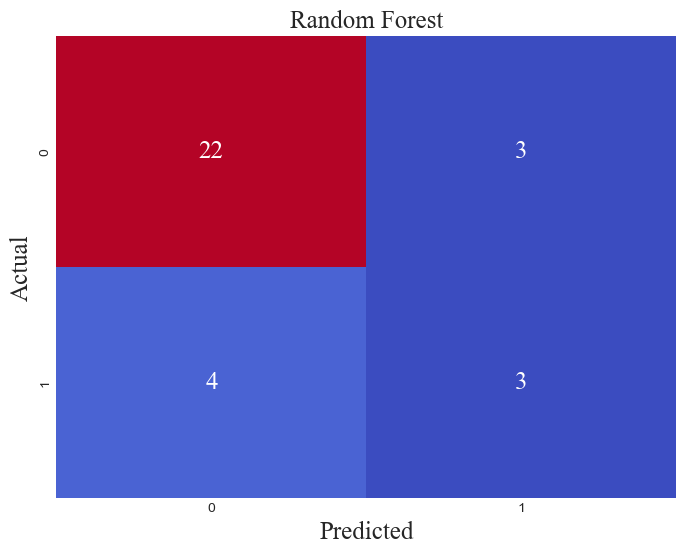

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("coolwarm", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Random Forest', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()


# For a hyperparameter table 

In [23]:
import pandas as pd
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

# Define the parameter grid
param_grid = {
    'm__n_estimators': [100, 200, 300],
    'm__class_weight': [{0: 0.6428571428571429, 1: 2.25}, None],
    'm__max_depth': [None, 10, 20],
    's__n_features_to_select': [5, 1, 15]
}

# Create the pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

# Outer cross-validation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Initialize a DataFrame to store the results
results_df = pd.DataFrame()

# Iterate through each combination of parameters
for params in ParameterGrid(param_grid):
    # Set the parameters of the pipeline
    pipeline.set_params(**params)
    
    # Collect results for each fold
    fold_results = []
    for train_idx, test_idx in outer_cv.split(X_train_res, y_train_res):
        X_train, X_test = X_train_res.iloc[train_idx], X_train_res.iloc[test_idx]
        y_train, y_test = y_train_res[train_idx], y_train_res[test_idx]
        
        # Clone the pipeline to ensure independence
        clf = clone(pipeline)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Collect classification report and accuracy
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Append results to the fold_results
        fold_results.append({'params': params, 'accuracy': accuracy, 'report': report})
    
    # Average the results over the folds
    avg_accuracy = sum(result['accuracy'] for result in fold_results) / len(fold_results)
    
    # Handle averaging of the classification report
    avg_report = {}
    avg_precision = 0
    avg_recall = 0
    avg_f1_score = 0
    for label in fold_results[0]['report']:
        if isinstance(fold_results[0]['report'][label], dict):
            avg_report[label] = {
                metric: sum(fold_result['report'][label][metric] for fold_result in fold_results) / len(fold_results)
                for metric in fold_results[0]['report'][label]
            }
            if label == 'weighted avg':
                avg_precision = avg_report[label]['precision']
                avg_recall = avg_report[label]['recall']
                avg_f1_score = avg_report[label]['f1-score']
        else:
            avg_report[label] = sum(fold_result['report'][label] for fold_result in fold_results) / len(fold_results)
    
    # Add the results to the DataFrame using pd.concat
    new_row = pd.DataFrame({
        'params': [params], 
        'accuracy': [avg_accuracy], 
        'precision': [avg_precision], 
        'recall': [avg_recall], 
        'f1-score': [avg_f1_score], 
        'report': [avg_report]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('/Users/dionnespaltman/Desktop/V4/hyperparameters/grid_search_results.csv', index=False)

# Print the results
print(results_df)

KeyboardInterrupt: 